# Get the haversine masking to work

In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import sys
sys.path.append('../sat2habitat')
import crisp
from datasets import SatHabData
from config import config
from torch.utils.data import DataLoader
from crisp import create_distance_mask, haversine_distances

/home/cher/miniconda3/envs/clippatch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
im_dir = config.im_dir
im_dir_val = config.im_dir_val
train_csv_path = config.train_csv_path
val_csv_path = config.val_csv_path
    
# Import dataset
train_dataset = SatHabData(im_dir, train_csv_path)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Take a single batch of size 64
im_embeds, text_embeds, coords, *_ = next(iter(train_loader))

# Create a haversine distance mask

# Is this calculated correctly in the model?

In [14]:
text_embeds.shape

torch.Size([256, 1, 77])

In [16]:
# Remove the extra dimension
text_embeds.squeeze(1).shape

torch.Size([256, 77])

In [47]:
haversine_distances(coords)

tensor([[      0.0000,  740293.7905,  878497.8492,  ..., 3211751.8995,
          616226.5562,  782195.9547],
        [ 740293.7905,       0.0000,  548791.6458,  ..., 2598144.1675,
         1355170.7637,  952859.6788],
        [ 878497.8492,  548791.6458,       0.0000,  ..., 2345117.1222,
         1390499.0740, 1409043.9576],
        ...,
        [3211751.8995, 2598144.1675, 2345117.1222,  ...,       0.0000,
         3728953.4215, 3525629.3753],
        [ 616226.5562, 1355170.7637, 1390499.0740,  ..., 3728953.4215,
               0.0000, 1131631.9007],
        [ 782195.9547,  952859.6788, 1409043.9576,  ..., 3525629.3753,
         1131631.9007,       0.0000]], dtype=torch.float64)

In [51]:
crisp.create_distance_mask(coords, distance_threshold = 250)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

Decay rate

In [17]:
import numpy as np

def compute_weights_with_threshold(distances, distance_threshold):
    """
    Compute exponential weights based on distance and a distance threshold.

    Parameters:
    - distances (numpy.ndarray): Array of distances.
    - distance_threshold (float): The threshold controlling the exponential decay.

    Returns:
    - numpy.ndarray: Array of weights (0 for distances beyond the threshold).
    """
    weights = np.exp(-distances / distance_threshold)  # Compute exponential weights
    weights[distances > distance_threshold] = 0  # Mask values beyond the threshold
    return weights

# Example usage
distances = np.array([50, 100, 200, 300, 500])  # Example distances in meters
distance_threshold = 100  # Threshold in meters

weights = compute_weights_with_threshold(distances, distance_threshold)
print("Distances:", distances)
print("Weights:", weights)


Distances: [ 50 100 200 300 500]
Weights: [0.60653066 0.36787944 0.         0.         0.        ]


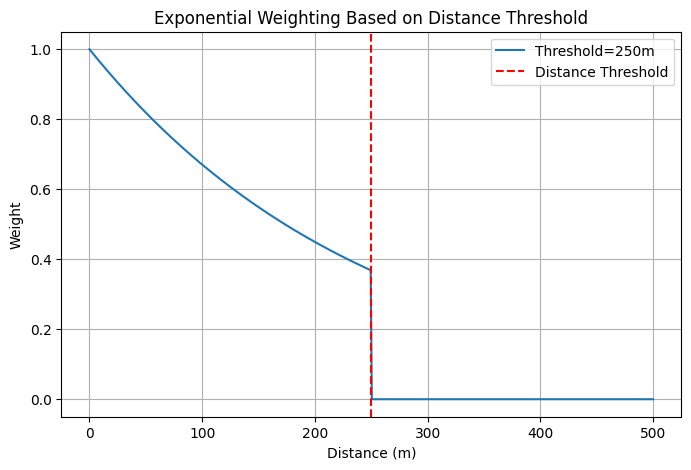

In [14]:
import matplotlib.pyplot as plt

# Generate distances for visualization
distances = np.linspace(0, 500, 500)

# Compute weights
distance_threshold = 250
weights = compute_weights_with_threshold(distances, distance_threshold)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(distances, weights, label=f"Threshold={distance_threshold}m")
plt.axvline(x=distance_threshold, color="red", linestyle="--", label="Distance Threshold")
plt.title("Exponential Weighting Based on Distance Threshold")
plt.xlabel("Distance (m)")
plt.ylabel("Weight")
plt.legend()
plt.grid()
plt.show()


Test how many pairs (in batches) are within different distance thresholds

In [23]:
train_ds = SatHabData(im_dir, train_csv_path)
train_dataloader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True)


In [24]:
import json
import matplotlib.pyplot as plt

# Function to count pairs within thresholds
def count_pairs_within_thresholds(coords, thresholds):
    distances = haversine_distances(coords)  # Pairwise distances
    counts = {}
    for threshold in thresholds:
        counts[threshold] = (distances <= threshold).sum().item()
    return counts

In [ ]:
thresholds = [250, 500, 1000, 2000, 5000]
results = []

# Loop through batches and save results
for epoch in range(1):
    for i, batch in enumerate(train_dataloader):
        _, _, coords = batch
        coords = coords.to('cuda')  # Ensure coords are on the right device
        counts = count_pairs_within_thresholds(coords, thresholds)
        
        results.append({'batch': i + 1, 'counts': counts})
        print(f"Batch {i+1}: {counts}")

Batch 1: {250: 266, 500: 270, 1000: 282, 2000: 288, 5000: 296}
Batch 2: {250: 266, 500: 266, 1000: 270, 2000: 284, 5000: 294}
Batch 3: {250: 264, 500: 264, 1000: 272, 2000: 276, 5000: 282}
Batch 4: {250: 262, 500: 264, 1000: 266, 2000: 270, 5000: 276}
Batch 5: {250: 262, 500: 266, 1000: 272, 2000: 278, 5000: 300}
Batch 6: {250: 268, 500: 268, 1000: 270, 2000: 274, 5000: 284}
Batch 7: {250: 266, 500: 266, 1000: 270, 2000: 272, 5000: 278}
Batch 8: {250: 264, 500: 264, 1000: 272, 2000: 276, 5000: 290}
Batch 9: {250: 260, 500: 260, 1000: 266, 2000: 274, 5000: 294}
Batch 10: {250: 266, 500: 266, 1000: 266, 2000: 272, 5000: 286}
Batch 11: {250: 270, 500: 270, 1000: 276, 2000: 280, 5000: 294}
Batch 12: {250: 272, 500: 276, 1000: 282, 2000: 288, 5000: 308}
Batch 13: {250: 266, 500: 268, 1000: 270, 2000: 276, 5000: 286}
Batch 14: {250: 266, 500: 268, 1000: 268, 2000: 268, 5000: 270}
Batch 15: {250: 274, 500: 276, 1000: 286, 2000: 294, 5000: 304}
Batch 16: {250: 266, 500: 270, 1000: 274, 2000: 2

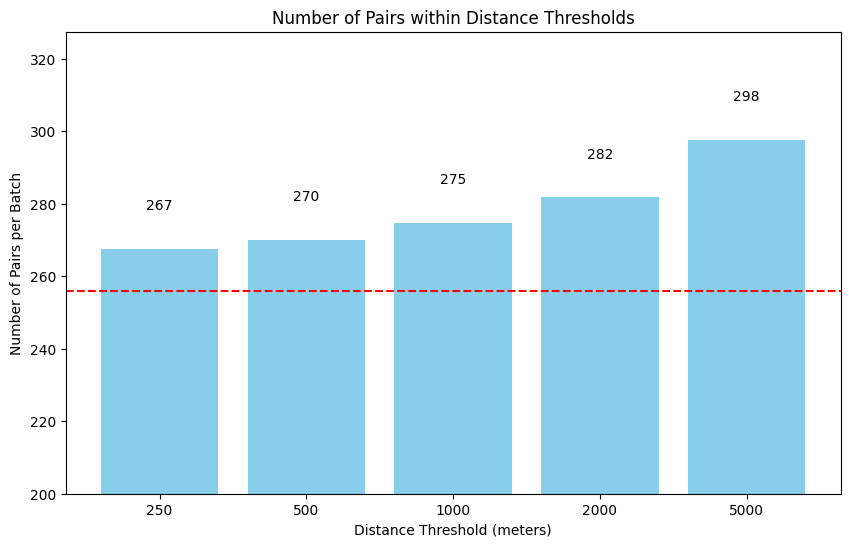

In [ ]:
# Aggregate counts across all batches
aggregated_counts = {str(threshold): 0 for threshold in thresholds}
for batch_result in results:
    for threshold, count in batch_result['counts'].items():
        aggregated_counts[str(threshold)] += count

# Plotting
thresholds_str = [str(threshold) for threshold in thresholds]
counts_per_batch = [aggregated_counts[th] / len(results) for th in thresholds_str]

plt.figure(figsize=(10, 6))
bars = plt.bar(thresholds_str, counts_per_batch, color='skyblue')
plt.axhline(y=config.batch_size, color='red', linestyle='--', label=f'Batch Size ({config.batch_size})')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{round(height)}', ha='center', va='bottom', fontsize=10)

# Configure axis
plt.ylim(200, max(counts_per_batch) * 1.1)  # Start y-axis at 200 and scale up a bit for aesthetics

plt.xlabel("Distance Threshold (meters)")
plt.ylabel("Number of Pairs per Batch")
plt.title("Number of Pairs within Distance Thresholds")
plt.show()


In [47]:
for cnt in counts_per_batch:
    print(round(100 * (cnt / config.batch_size - 1)))

4
5
7
10
16
